ISyE 6402, Code for Final Project, Hongzhao Guan, 902913235

Notes: This Jupyter Notebook is written in R. If you want to run the whole notebook, please make sure you have Data folder included in the directory.

Part 1: process data

In [251]:
# First, let's load the dat about Electric and Gas Utilities
options(warn=-1)
dir  = getwd()
data = read.csv("./Data/Tractor-Sales.csv")

In [201]:
months = as.vector(t(data[, 1]))
sales  = as.vector(t(data[, 2]))

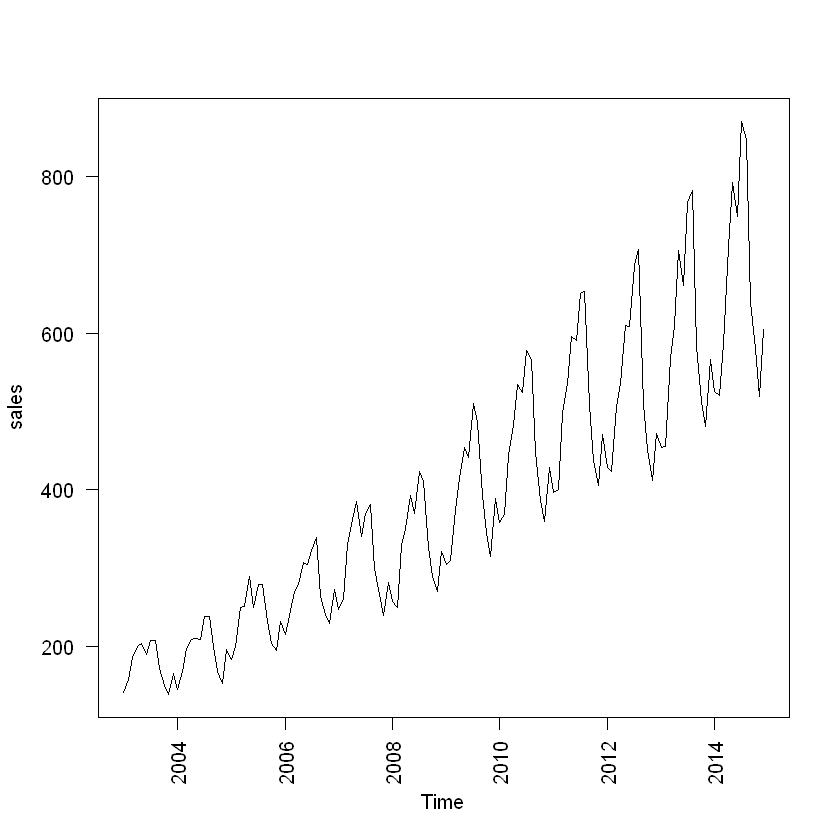

In [202]:
sales = ts(sales, start = 2003, frequency = 12)
par(las = 2)
ts.plot(sales, ylab = "sales")

Part 2: Trend and Seasonality Estimation

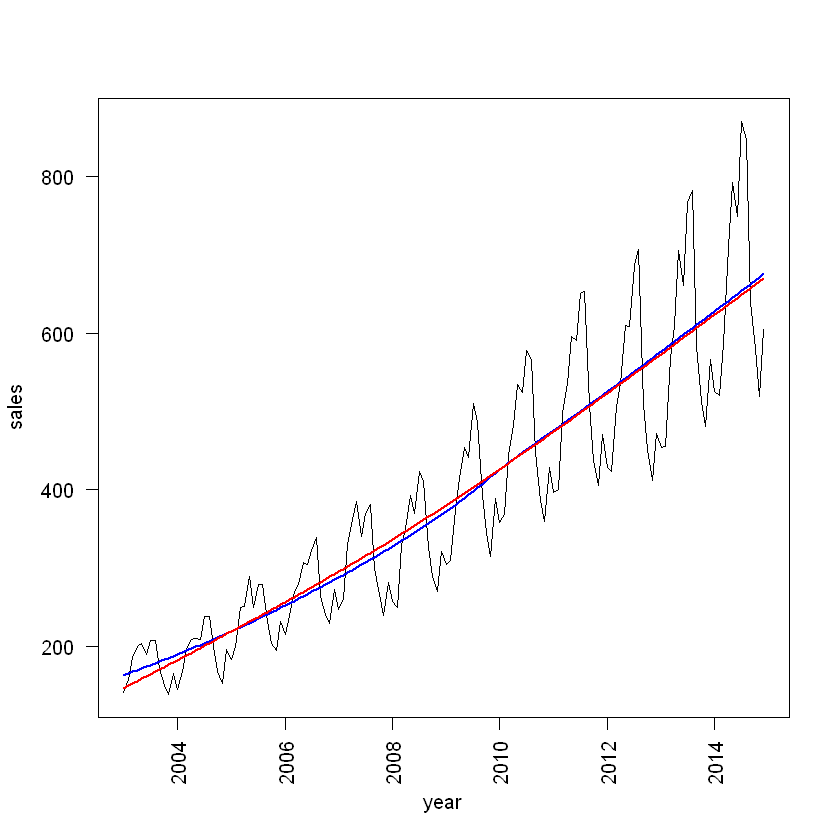

In [203]:
### In this block, we do Trend Estimation
time.pts = c(1 : length(sales))
time.pts = c(time.pts - min(time.pts)) / max(time.pts)


## Local Polynomial Trend Estimation
loc.fit       = loess(sales~time.pts)
sales.fit.loc = ts(fitted(loc.fit), start = 2003, frequency = 12)


## Splines Trend Estimation
library(mgcv)
gam.fit       = gam(sales~s(time.pts))
sales.fit.gam = ts(fitted(gam.fit), start = 2003, frequency = 12)


## Splines Trend Estimation
par(las = 2)
ts.plot(sales, ylab = "sales", xlab = "year")
lines(sales.fit.loc, lwd = 2, col = "blue")
lines(sales.fit.gam, lwd = 2, col = "red")

In [204]:
summary(gam.fit)


Family: gaussian 
Link function: identity 

Formula:
sales ~ s(time.pts)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   389.69       6.29      62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
             edf Ref.df   F p-value    
s(time.pts) 1.94   2.43 245  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.806   Deviance explained = 80.9%
GCV =   5816  Scale est. = 5697.1    n = 144

First, the p-value indicates that a smooth trend is statiscally significant
Second, the adjusted R-squared score is 0.806. Implying that about 80% of the variablity in the Tractor Sales is explained by the Trend Alone.

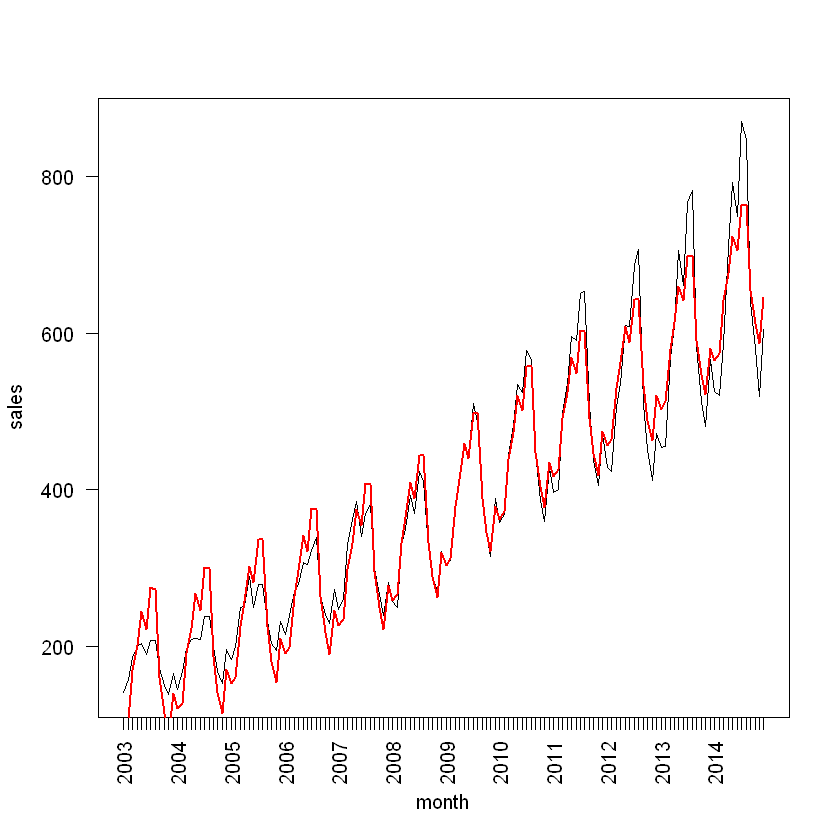

In [205]:
## In this block, we do Seasonality Estimation
library(zoo)
month = as.yearmon(months, "%b-%y")
mon  = as.factor(format(month, "%b"))
gam.fit.seastr = gam(sales~s(time.pts) + mon)
options(digits = 2)
sales.fit.gam.seastr = fitted(gam.fit.seastr)
par(las = 2)
plot(month, sales, type = "l")
lines(month, sales.fit.gam.seastr, lwd = 2, col = "red")

In [206]:
summary(gam.fit.seastr)


Family: gaussian 
Link function: identity 

Formula:
sales ~ s(time.pts) + mon

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    420.7       10.5   40.12  < 2e-16 ***
monAug          65.6       14.8    4.42  2.1e-05 ***
monDec         -74.6       14.9   -5.02  1.8e-06 ***
monFeb         -91.7       14.8   -6.19  8.0e-09 ***
monJan         -96.1       14.8   -6.49  1.8e-09 ***
monJul          69.6       14.8    4.69  6.9e-06 ***
monJun          17.7       14.8    1.20   0.2335    
monMar         -29.7       14.8   -2.00   0.0475 *  
monMay          41.6       14.8    2.81   0.0058 ** 
monNov        -127.7       14.9   -8.60  2.7e-14 ***
monOct         -97.5       14.8   -6.57  1.2e-09 ***
monSep         -48.8       14.8   -3.29   0.0013 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
             edf Ref.df   F p-value    
s(time.pts) 5.99   7.15 363  <2e-16 ***
---
Signif. cod

Most Regression coefficients are statistically significant. This indicates a yearly seasonality in the model.
R-square value is equal to 0.955, indicates that about 95.5% of the model is explained.

Part 3: Residual Process

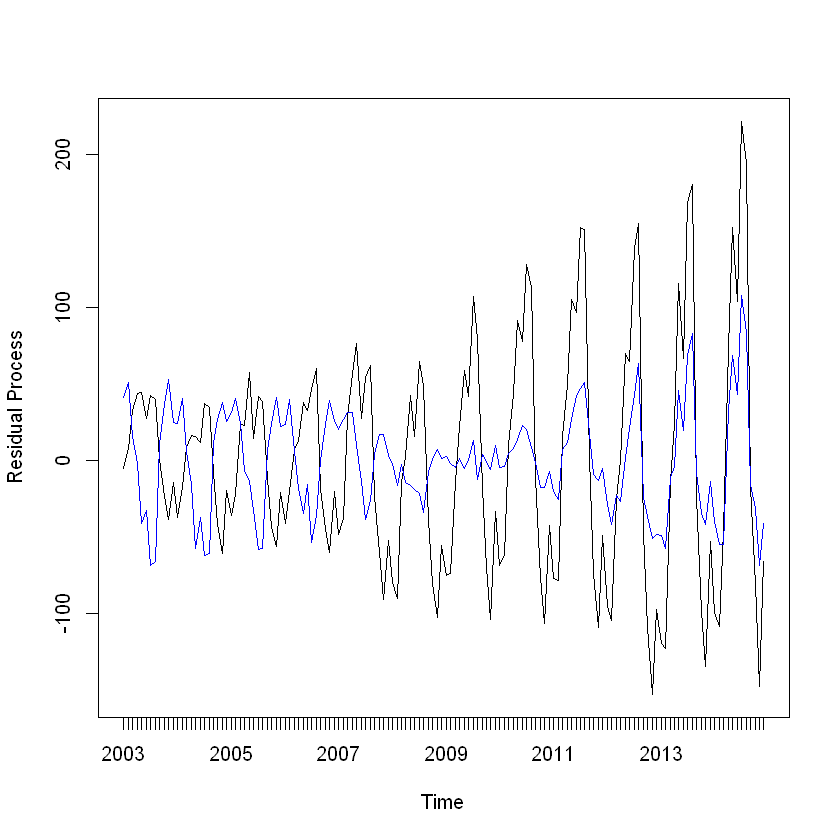

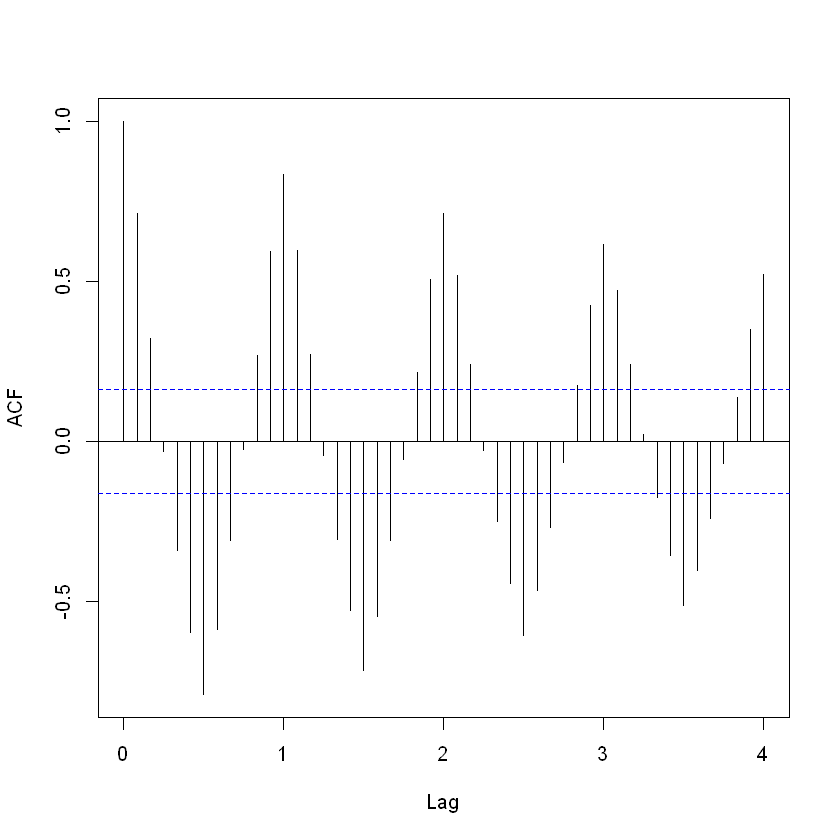

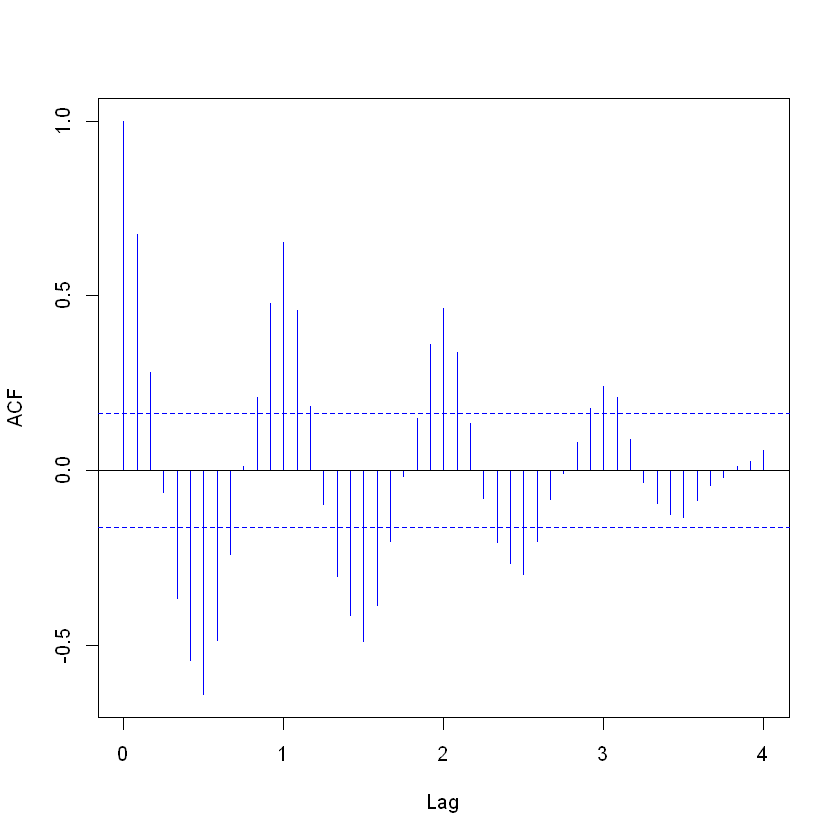

In [207]:
## Trend Removal
resid.1 = sales - sales.fit.gam

## remove both trend and seasonality
resid.2 = sales - sales.fit.gam.seastr


y.min = min(c(resid.1, resid.2))
y.max = max(c(resid.1, resid.2))

# Show Residual
plot(dates,resid.1, type='l',ylab="Residual Process",xlab='Time')
lines(dates,resid.2,col="blue")

acf(resid.1, lag.max = 12*4, main="")
acf(resid.2, lag.max = 12*4, main="", col="blue")

Part 4: Fitting ARIMA

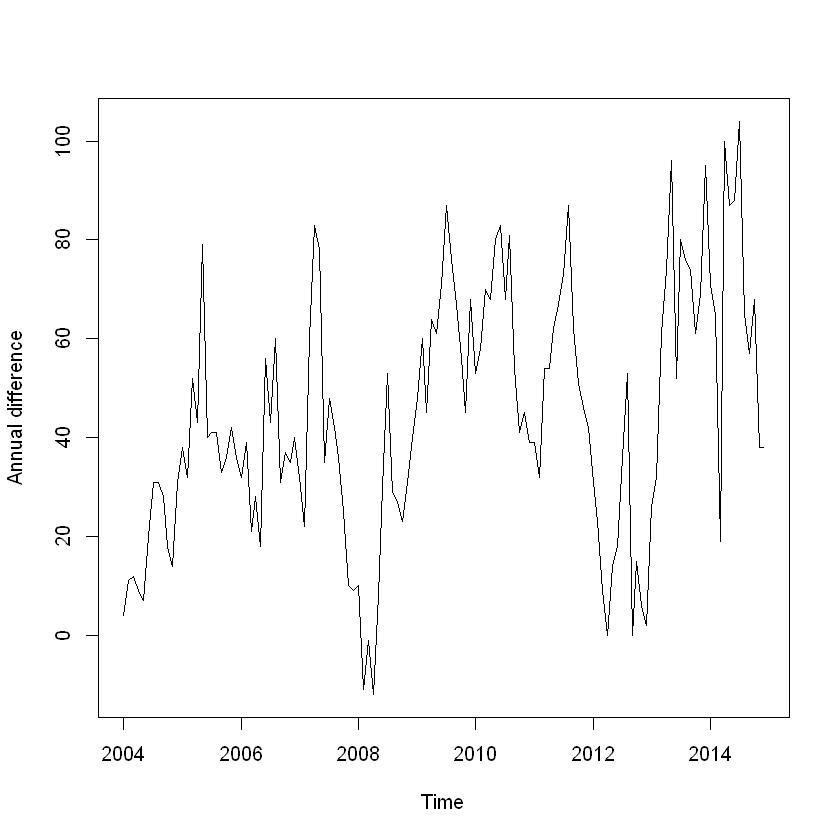

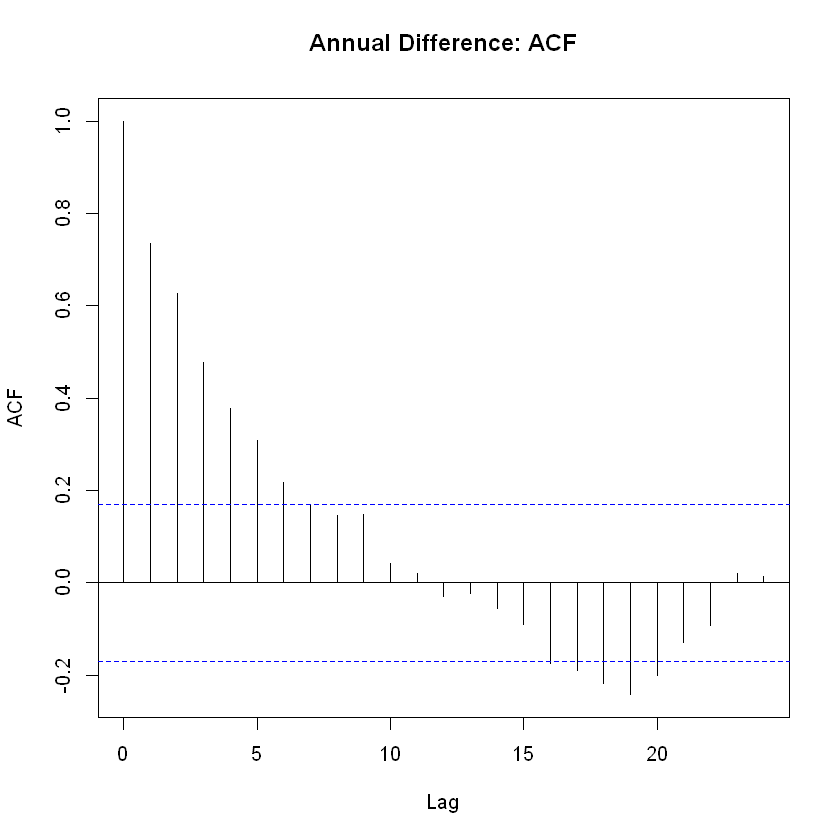

In [208]:
# Differencing the data
dSales12 = diff(sales, 12) # Annual
ts.plot(dSales12,  ylab = "Annual difference")
acf(as.vector(dSales12), main='Annual Difference: ACF', lag.max = 12 * 2)

In [255]:
# Fit Arima
arima_order  = c(2, 1, 2)
season_order = c(1, 0, 1)
mod = arima(sales, order = arima_order, seasonal = list(order = season_order, period = 12), method = "ML")

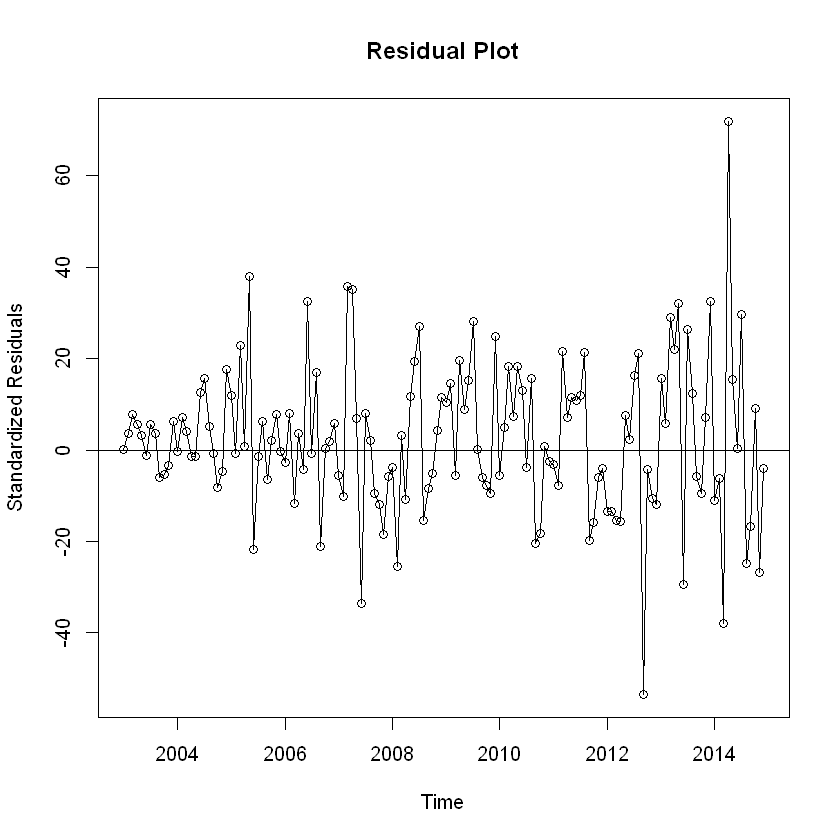

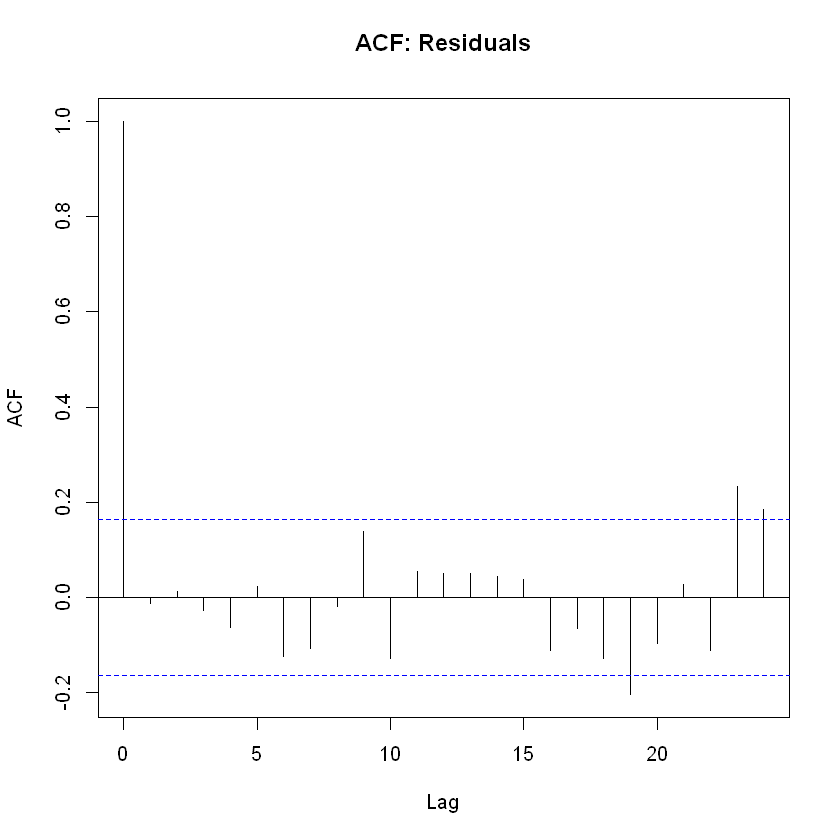

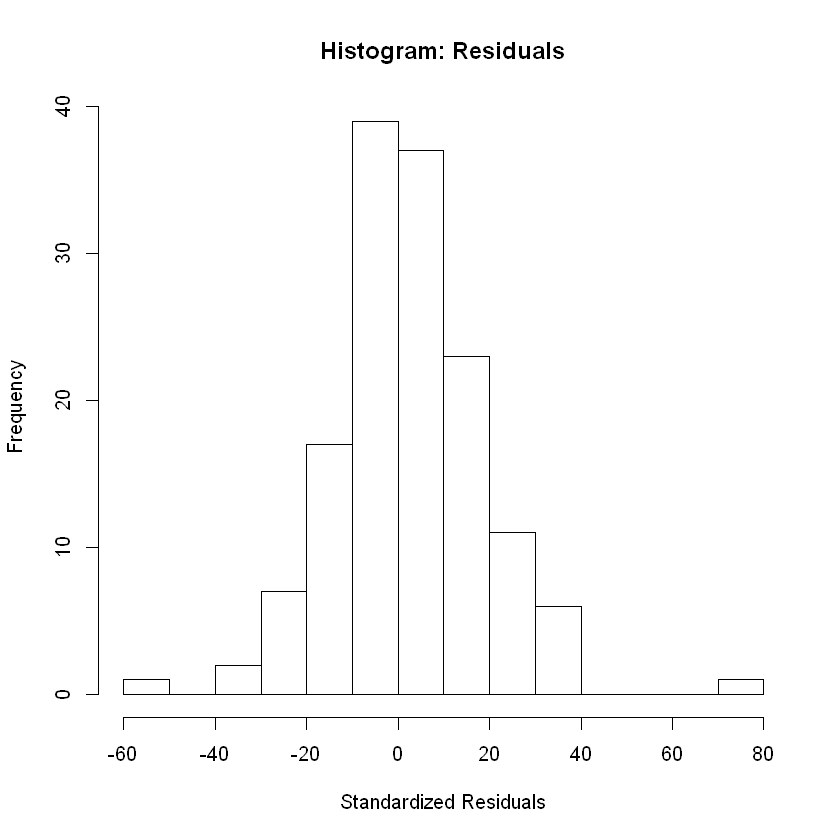

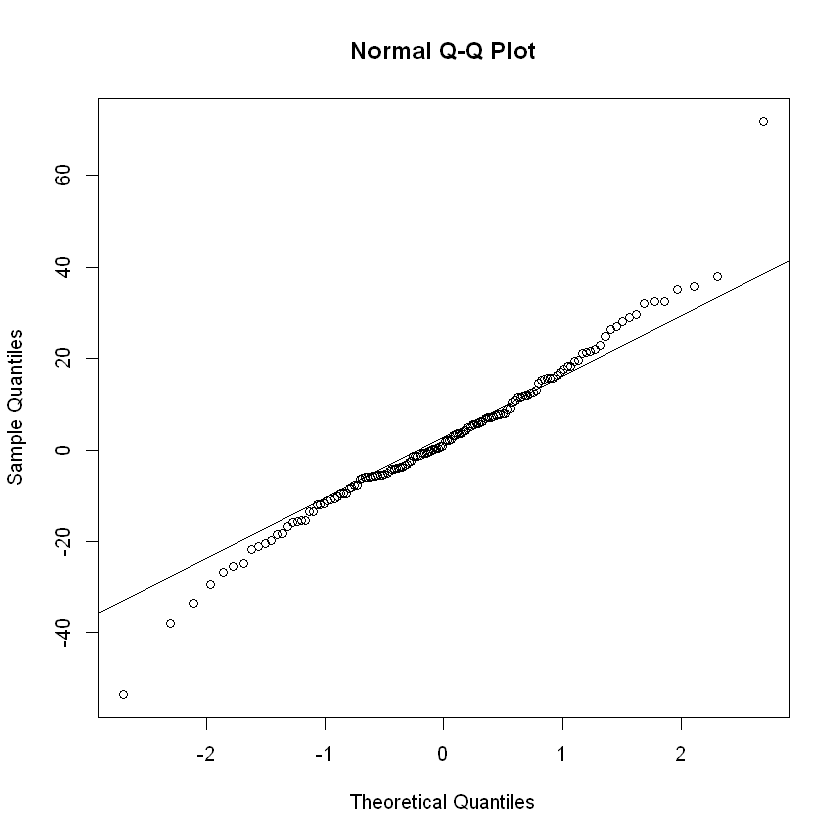

In [256]:
# Show results from the ARIMA model
plot(resid(mod), ylab = 'Standardized Residuals', type = 'o',main = "Residual Plot")
abline(h = 0)
acf(as.vector(resid(mod)), lag.max = 12 * 2, main="ACF: Residuals")
hist(resid(mod),xlab = 'Standardized Residuals', main = 'Histogram: Residuals')
qqnorm(resid(mod))
qqline(resid(mod))

The Last Part: Fore casting using ARIMA

In [257]:
# Forecasting with ARIMA, three years ahead
ahead      = 36
n          = length(sales)
nfit       = n - ahead 
outSales   = arima(sales[1 : nfit], order = arima_order, seasonal = list(order = season_order, period = 12),method = "ML")
Sales_pred = as.vector(predict(outSales, n.ahead = ahead ))

In [258]:
# set up bounds
timeSales = time(sales)
ubound    = Sales_pred$pred + 1.96 * Sales_pred$se
lbound    = Sales_pred$pred - 1.96 * Sales_pred$se
ymin      = min(lbound)
ymax      = max(ubound)

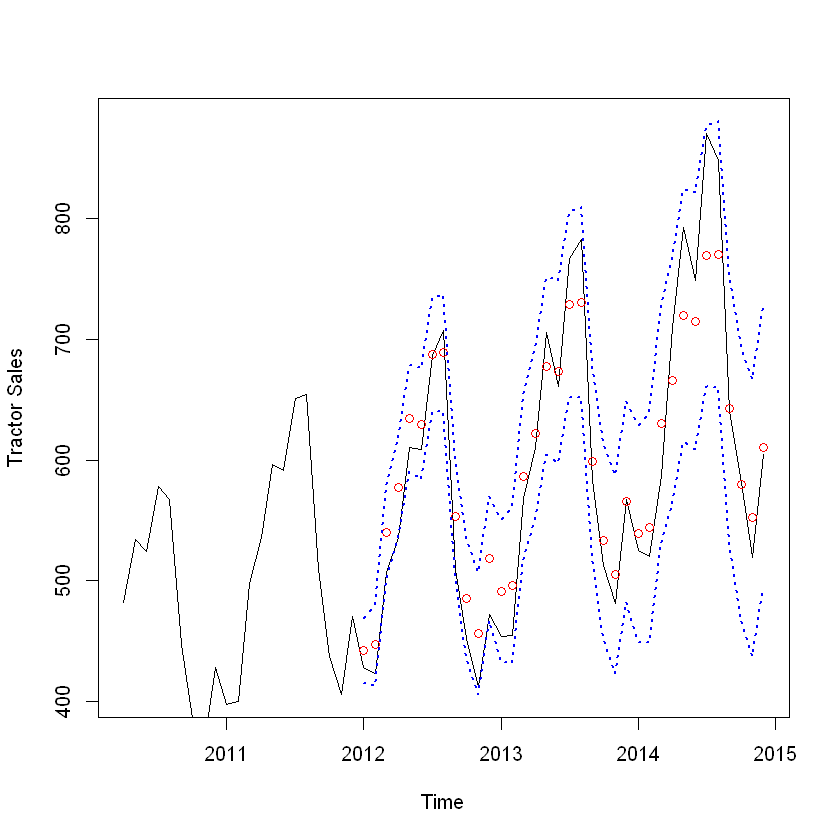

In [259]:
# Show Forecasting Results
par(mfrow=c(1,1))
plot(timeSales[(n - 56) : n], sales[(n - 56) : n], type = "l", ylim=c(ymin, ymax), xlab = "Time", ylab = "Tractor Sales")
points(timeSales[(nfit+ 1) : n], Sales_pred$pred,col = "red")
lines(timeSales[(nfit + 1) : n], ubound, lty = 3, lwd = 2, col = "blue")
lines(timeSales[(nfit + 1) : n], lbound, lty = 3, lwd = 2, col = "blue")